# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv(url)

In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Данных для задачии регрессии может быть не достаточно. Что бы увеличить кол-во фотографий мы можем применить аугментацию.

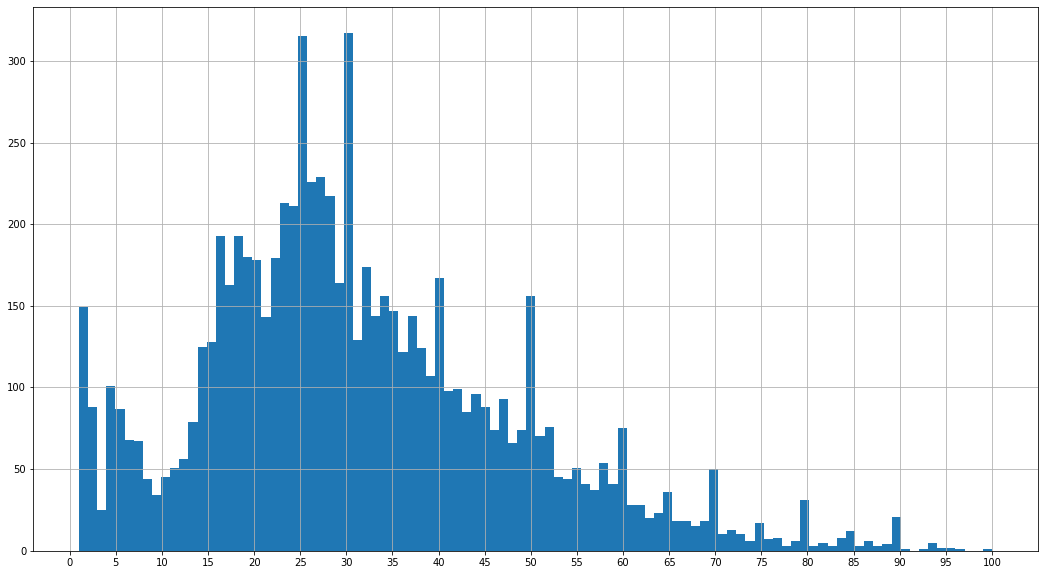

In [4]:
plt.figure(figsize=(18, 10))
labels.real_age.hist(bins=100);
plt.xticks(range(0,101,5));

- Больше всего файлов с 20 по 30 лет.
- Есть пики в юбилейные годы 30, 40, 50, 60, 70, 80, 90 похоже на то что возваст был округлен на некоторых фотографиях.

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
features, target = next(gen_flow)

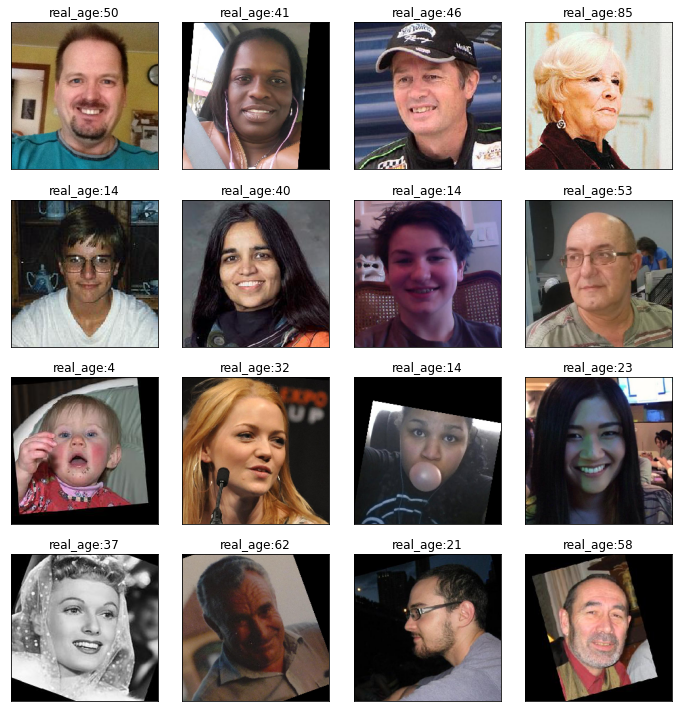

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('real_age:'+ str(target[i]))

- На некоторых уже выровнено положение лица, т.е. нет необходимости поворачивать фотографии. 
- На некоторых фотографиях есть черные рамки, которые не несут полезной информации. 
- Начальный размер изображений отличается - заметно различное качество фотографий. 
- Перед обучением модели приведем изображения к единому размеру 224x224.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense,  GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

        model.fit(train_data,
                  validation_data=test_data,
                  batch_size=batch_size,
                  epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  verbose=2, shuffle=True)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/15
356/356 - 114s - loss: 185.5041 - mae: 10.2212 - val_loss: 482.1151 - val_mae: 16.8152
Epoch 2/15
356/356 - 38s - loss: 94.9282 - mae: 7.4445 - val_loss: 246.4943 - val_mae: 11.6199
Epoch 3/15
356/356 - 38s - loss: 65.0619 - mae: 6.1765 - val_loss: 106.1728 - val_mae: 8.0595
Epoch 4/15
356/356 - 38s - loss: 39.7007 - mae: 4.8707 - val_loss: 87.2613 - val_mae: 7.0952
Epoch 5/15
356/356 - 38s - loss: 27.5776 - mae: 4.0321 - val_loss: 94.7459 - val_mae: 7.6680
Epoch 6/15
356/356 - 38s - loss: 21.6527 - mae: 3.6069 - val_loss: 86.2529 - val_mae: 7.2047
Epoch 7/15
356/356 - 38s - loss: 16.1519 - mae: 3.0694 - val_loss: 73.9555 - val_mae: 6.5300
Epoch 8/15
356/356 - 38s - loss: 13.2760 - mae: 2.7893 - val_loss: 74.0590 - val_mae: 6.6695
Epoch 9/15
356/356 - 38s - loss: 12.9755 - mae: 2.7460 - val_loss: 153.2022 - val_mae: 10.1999
Epoch 10/15
356/356 - 38s - loss: 15.1910 - mae: 2.9861 - val_loss: 82.9787 - val_mae: 7.0198
Epoch 11/15
356/356 - 38s - loss: 16.3538 - mae: 3.1043 - val_loss: 85.1037 - val_mae: 6.7833
Epoch 12/15
356/356 - 40s - loss: 15.2588 - mae: 2.9748 - val_loss: 92.9586 - val_mae: 7.1837
Epoch 13/15
356/356 - 42s - loss: 13.7914 - mae: 2.8418 - val_loss: 77.4272 - val_mae: 6.7086
Epoch 14/15
356/356 - 42s - loss: 12.8124 - mae: 2.7323 - val_loss: 92.1917 - val_mae: 7.3794
Epoch 15/15
356/356 - 44s - loss: 10.6307 - mae: 2.4820 - val_loss: 71.5586 - val_mae: 6.3789

119/119 - 10s - loss: 71.5586 - mae: 6.3789
Test MAE: 6.3789

```

## Анализ обученной модели

- Архитектура модели RestNet50 с весами ImageNet, оптимизатором Adam(learning_rate=0.0003) и функция потерь MSE.
- Модель преодолела порог в 8 на 4 эпохе, а на 15 эпохе мы имеем MAE=6.3789.
- Для контроля добросовестности кассиров при продаже алкоголя, наша модель не подойдет, так как имеем в среднем ошибку в 6 лет, а это критично при продаже юным покупателям.